In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import models as model_vae
from models import VAE

In [ ]:
import torch
import torch.nn as nn

from torch.nn import MSELoss
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
from torch.optim import Adam, SGD

import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

In [ ]:
size_image = 256
device = torch.device('cuda:0')

In [ ]:
to_img = transforms.ToPILImage()

In [ ]:
transform = transforms.Compose([transforms.Resize(size_image),
                                transforms.CenterCrop(size_image),
                                transforms.ToTensor()])

In [ ]:
dataset_path = ImageFolder(r'drive/My Drive/myfacedataset_1/', 
                               transform=transforms.Compose([
                                   transforms.Resize(size_image),
                                   transforms.CenterCrop(size_image),
                                #    transforms.RandomChoice([
                                #         transforms.RandomRotation(45),
                                #         transforms.RandomAdjustSharpness(1.5),
                                #         transforms.RandomPosterize(3)
                                #    ]),
                                transforms.ToTensor()
                               ]))

In [ ]:
dataset_path.classes

['bald', 'glasses', 'hat', 'helmet', 'normhair', 'redhead', 'vk']

In [ ]:
my_faces = DataLoader(
    dataset_path,
    batch_size=40,
    shuffle=True,
    num_workers=4
    )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
path = r'drive/My Drive/VAE weights/'

In [ ]:
new_VAE = torch.load(f'{path}VAEgenerator_best')

In [ ]:
optimizer = Adam(new_VAE.parameters(), lr=3e-4)
loss_mse = MSELoss()

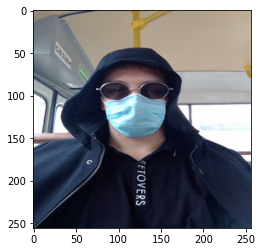

In [ ]:
img = 'drive/My Drive/myfacedataset_1/vk/11.jpg'
_img = Image.open(img)
plt.imshow(_img)

In [ ]:
def show_img(vae, img, to_img):
    fig, axes = plt.subplots(1, 2)

    img = Image.open(img)
    img = transform(img)

    img_ = to_img(img)
    axes[0].imshow(img_)
    axes[0].set_title('Изначальное фото')

    img = img.to(device)
    img = vae(img.view(1, 3, size_image, size_image))
    img.shape
    a = img.view(3, size_image, size_image).to('cpu')
    to_img = transforms.ToPILImage()
    a = to_img(a)

    axes[1].imshow(a)
    axes[1].set_title('Восстановленное')

    fig.set_figwidth(12)
    fig.set_figheight(6)

    plt.show()

In [ ]:
def show_vector_img(vae, vector, to_img=to_img):
    vector = vector.to(device)
    out = new_VAE.decoder(vector)
    
    out = to_img(out.view(3, size_image, size_image).cpu().detach())

    plt.imshow(out)

In [ ]:
def rng_result(vae, vector_len=100, to_img=to_img, device=device):
    vector = torch.Tensor(np.random.random((1, vector_len)))
    show_vector_img(vae, vector, to_img)


In [ ]:
for param in new_VAE.parameters():
    param.requires_grad = True

In [ ]:
def train(vae, optimizer, dataloader, path, device, epochs):
    
    for epoch in range(vae.epoch, epochs + 1):

        print(epoch)

        for imgs, _ in dataloader:

            imgs = imgs.float().to(device)

            optimizer.zero_grad()

            # y_pred, mu, log_var = vae(imgs)

            y_pred = vae(imgs)

            loss = loss_mse(y_pred, imgs)

            loss.backward()
            optimizer.step()

        vae.epoch += 1
        print(loss)
        
        if loss < vae.best_loss:
            torch.save(vae, f'{path}VAEgenerator_best')
            vae.best_loss = loss
            
        if not epoch % 50:
            torch.save(vae, f'{path}VAEgenerator_last')

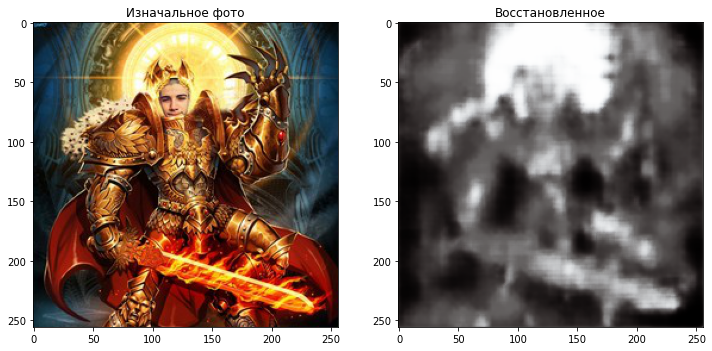

In [ ]:
img = 'drive/My Drive/myfacedataset_1/vk/25.jpg'
show_img(new_VAE, img, to_img)

In [ ]:
# new_VAE.epochs = 0
new_VAE.to(device)
new_VAE.train()

VAE(
  (encoder): Encoder(
    (main): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout2d(p=0.25, inplace=False)
      (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout2d(p=0.25, inplace=False)
      (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.01)
      (11): Dropout2d(p=0.25, inplace=False)
      (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): LeakyRe

In [ ]:
torch.cuda.is_available()

True

In [ ]:
%time
train(new_VAE, optimizer, my_faces, path, device, 10000)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.34 µs
6684


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Выходные данные были обрезаны до нескольких последних строк (5000).
tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward>)
7073
tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward>)
7074
tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward>)
7075
tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward>)
7076
tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward>)
7077
tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward>)
7078
tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward>)
7079
tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward>)
7080
tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward>)
7081
tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward>)
7082
tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward>)
7083
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward>)
7084
tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward>)
7085
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward>)
7086
tensor(0.0076, device='cuda:0', grad

Exception ignored in: <function _after_fork at 0x7fa31a8ef7a0>
Exception ignored in: <function _after_fork at 0x7fa31a8ef7a0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 1375, in _after_fork
  File "/usr/lib/python3.7/threading.py", line 1375, in _after_fork
    thread._reset_internal_locks(False)
  File "/usr/lib/python3.7/threading.py", line 811, in _reset_internal_locks
    thread._reset_internal_locks(False)


KeyboardInterrupt: ignored

    self._started._reset_internal_locks()
  File "/usr/lib/python3.7/threading.py", line 811, in _reset_internal_locks
  File "/usr/lib/python3.7/threading.py", line 505, in _reset_internal_locks
    self._started._reset_internal_locks()
    self._cond.__init__(Lock())
  File "/usr/lib/python3.7/threading.py", line 505, in _reset_internal_locks
  File "/usr/lib/python3.7/threading.py", line 231, in __init__
    self._cond.__init__(Lock())
    self._acquire_restore = lock._acquire_restore
  File "/usr/lib/python3.7/threading.py", line 227, in __init__
    self._release_save = lock._release_save
KeyboardInterrupt: 
KeyboardInterrupt: 


In [ ]:
%%time
train(new_VAE, optimizer, my_faces, path, device, 10000)
show_img(new_VAE, img, to_img)

In [ ]:
new_VAE.best_loss

tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>)

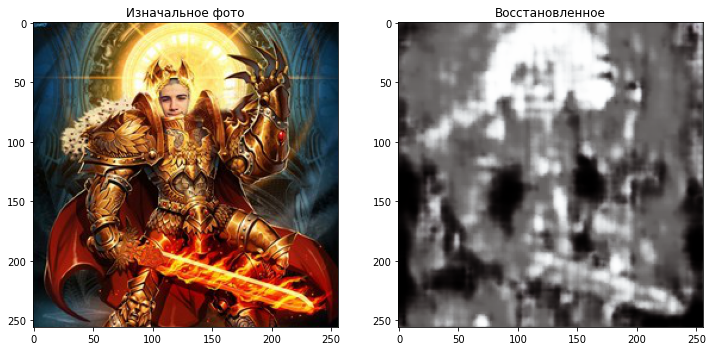

In [ ]:
show_img(new_VAE, img, to_img)